In [5]:
from utils import *

# Load training, validation, and test data
full_train_balanced, full_val, full_test = load_data()

# Get data loaders with no extra preprocessing
train_loader, val_loader, test_loader, test_dataset = get_data_loaders(full_train_balanced, full_val, full_test, 16, clahe_green_channel)

In [6]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import SwinForImageClassification

# Load pretrained DenseNet-121
densenet = models.densenet121(pretrained=True)

# Remove the classifier head
densenet_backbone = densenet.features

# Load pretrained Swin Transformer
swin_model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")

# Modify the input layer to accept DenseNet-121 features
swin_model.classifier = nn.Linear(in_features=1024, out_features=5)  # Assuming 5 DR severity levels



c:\Users\rylee\anaconda3\envs\dr\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rylee\anaconda3\envs\dr\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
class HybridModel(nn.Module):
    def __init__(self, densenet_backbone, swin_model):
        super(HybridModel, self).__init__()
        self.densenet = densenet_backbone
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling to match Swin input shape
        self.swin = swin_model

    def forward(self, x):
        x = self.densenet(x)  # Extract features using DenseNet-121
        x = self.pool(x).flatten(1)  # Pool and flatten for Swin Transformer
        x = self.swin.classifier(x)  # Final classification
        return x

# Initialize the hybrid model
model = HybridModel(densenet_backbone, swin_model)


Epoch 1/5
------------------------------


  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [1:58:14<00:00,  4.54s/it]


Train Loss: 1.1017 | Train Acc: 0.5175


100%|██████████| 243/243 [10:12<00:00,  2.52s/it]


Val Accuracy: 0.5193
Val Loss: 1.0121
Val Precision: 0.7434
Val Recall: 0.5193
Val F1 Score: 0.5844


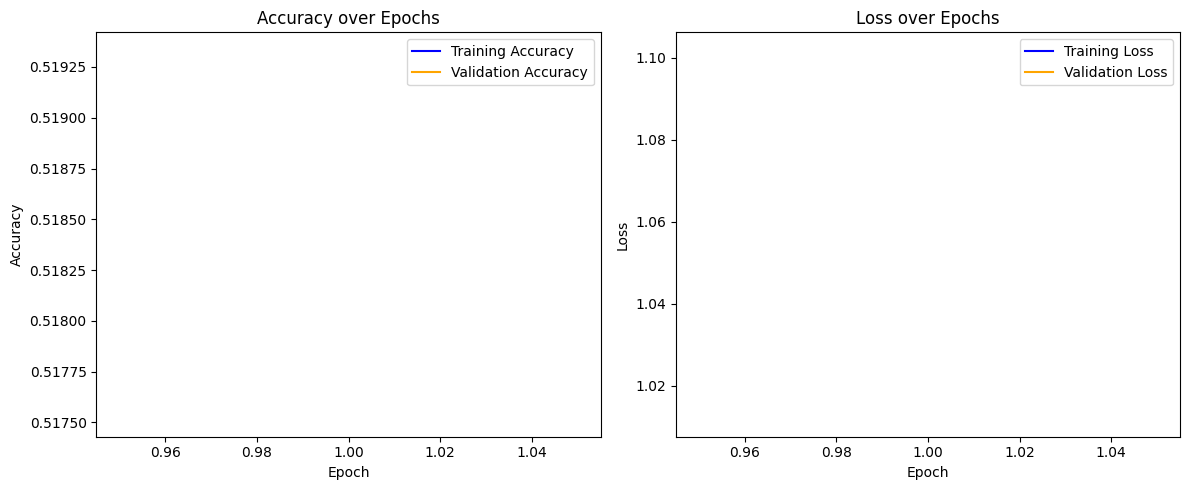

Epoch 2/5
------------------------------


100%|██████████| 1563/1563 [1:41:03<00:00,  3.88s/it]


Train Loss: 0.8414 | Train Acc: 0.6366


100%|██████████| 243/243 [09:17<00:00,  2.29s/it]


Val Accuracy: 0.5472
Val Loss: 0.9814
Val Precision: 0.7542
Val Recall: 0.5472
Val F1 Score: 0.6135


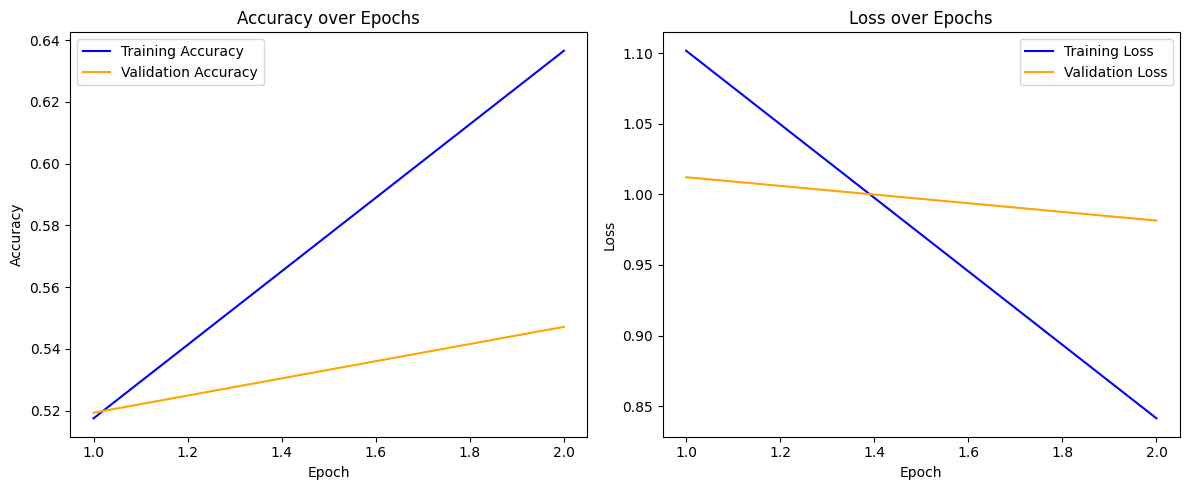

Epoch 3/5
------------------------------


100%|██████████| 1563/1563 [1:44:37<00:00,  4.02s/it]


Train Loss: 0.6812 | Train Acc: 0.7142


100%|██████████| 243/243 [12:24<00:00,  3.07s/it]


Val Accuracy: 0.6598
Val Loss: 0.8415
Val Precision: 0.7510
Val Recall: 0.6598
Val F1 Score: 0.6945


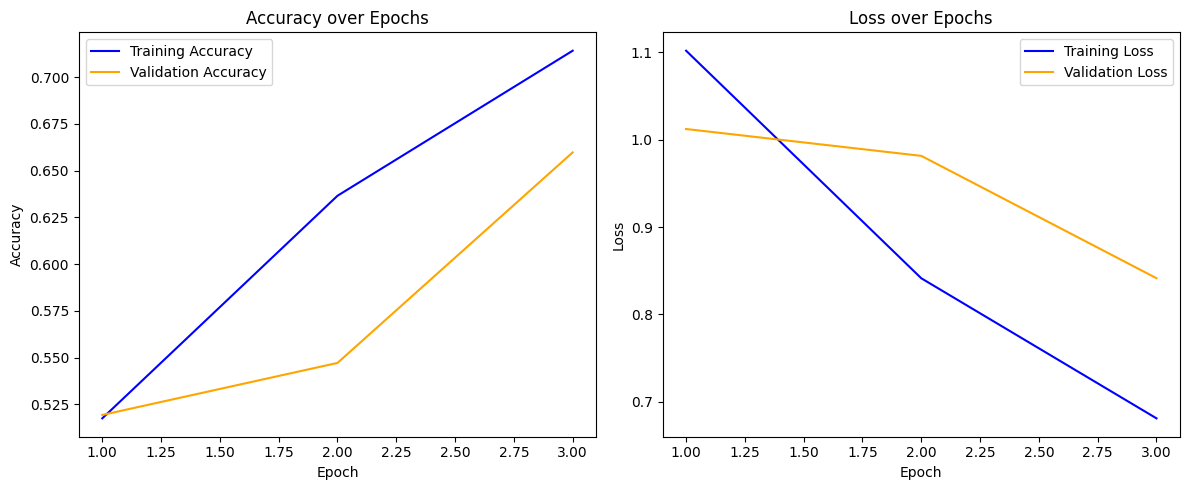

Epoch 4/5
------------------------------


100%|██████████| 1563/1563 [2:07:26<00:00,  4.89s/it] 


Train Loss: 0.5842 | Train Acc: 0.7580


100%|██████████| 243/243 [11:57<00:00,  2.95s/it]


Val Accuracy: 0.7062
Val Loss: 0.7747
Val Precision: 0.7623
Val Recall: 0.7062
Val F1 Score: 0.7268


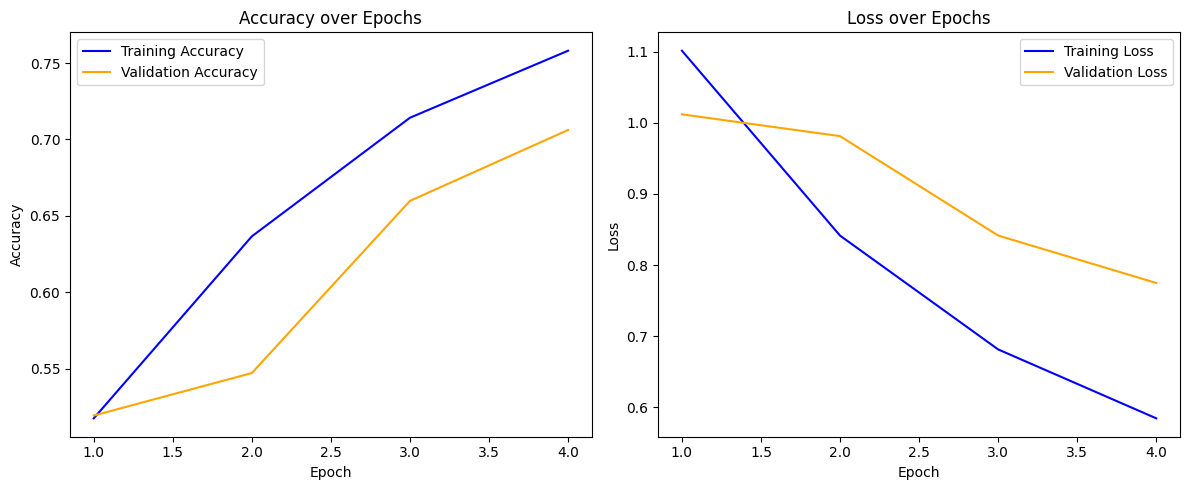

Epoch 5/5
------------------------------


100%|██████████| 1563/1563 [2:11:57<00:00,  5.07s/it] 


Train Loss: 0.5120 | Train Acc: 0.7938


100%|██████████| 243/243 [12:25<00:00,  3.07s/it]


Val Accuracy: 0.7039
Val Loss: 0.7759
Val Precision: 0.7519
Val Recall: 0.7039
Val F1 Score: 0.7237


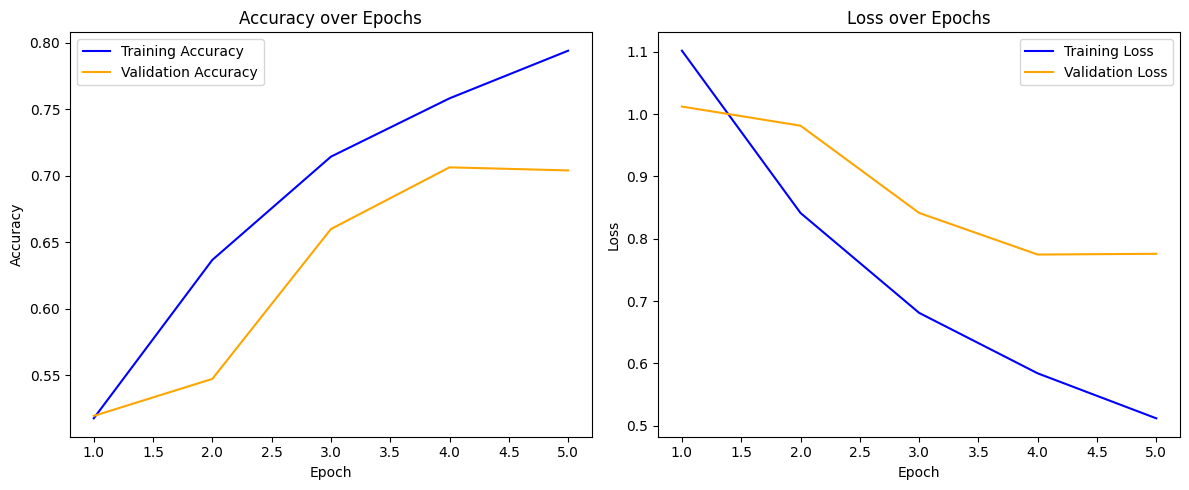

In [8]:
import torch
from torch import nn, optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

num_epochs = 5
val_accs = []
val_losses = []
train_accs = []
train_losses = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 30)

    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')

    acc, loss, precision, recall, f1 = evaluate(model, val_loader)
    val_accs.append(acc)
    val_losses.append(loss)

    print(f'Val Accuracy: {acc:.4f}')
    print(f'Val Loss: {loss:.4f}')
    print(f'Val Precision: {precision:.4f}')
    print(f'Val Recall: {recall:.4f}')
    print(f'Val F1 Score: {f1:.4f}')
    # Validation

    plot_accuracy_and_loss(train_accs, train_losses, val_accs, val_losses)

torch.save(model.state_dict(), 'denseNet/clahe_green_channel.pth')



In [4]:
model.load_state_dict(torch.load('denseNet/regular.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, test_loader)

print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')

100%|██████████| 485/485 [24:08<00:00,  2.99s/it]

Metrics for Aptos Dataset
Test Accuracy: 0.7328
Test Loss: 0.7896
Test  Precision: 0.7380
Test  Recall: 0.7328
Test  F1 Score: 0.7336


In [6]:
model.load_state_dict(torch.load('denseNet/gaussian_subtractive_normalization.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, test_loader)

print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')

100%|██████████| 440/440 [24:49<00:00,  3.39s/it]

Metrics for Aptos Dataset
Test Accuracy: 0.7490
Test Loss: 0.8135
Test  Precision: 0.7867
Test  Recall: 0.7490
Test  F1 Score: 0.7591
Metrics for DR Dataset
Test Accuracy: 0.6937
Test Loss: 0.8164
Test  Precision: 0.7313
Test  Recall: 0.6937
Test  F1 Score: 0.7082


In [9]:
model.load_state_dict(torch.load('denseNet/clahe_green_channel.pth'))
model.eval()

acc, loss, precision, recall, f1 = evaluate(model, test_loader)

print(f'Test Accuracy: {acc:.4f}')
print(f'Test Loss: {loss:.4f}')
print(f'Test  Precision: {precision:.4f}')
print(f'Test  Recall: {recall:.4f}')
print(f'Test  F1 Score: {f1:.4f}')

 73%|███████▎  | 354/485 [19:58<07:24,  3.39s/it]

In [112]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def visualize_gradcam(model, dataset, indexes):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.eval()
    cam = GradCAM(model, target_layers=[model.densenet[-1]])

    fig, axs = plt.subplots(1, 5, figsize=(20, 5))  # 1 row, 5 columns

    for i, ax in enumerate(axs):
        image, label = dataset[indexes[i]]
        image = image.unsqueeze(0).to(device)  # Add batch dim
        output = model(image)
        _, pred = torch.max(output, 1)

        grayscale_cam = cam(input_tensor=image)[0]

        rgb_img = image.squeeze().permute(1, 2, 0).cpu().numpy()
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        ax.imshow(cam_image)
        ax.set_title(f"True: {label} | Pred: {pred.item()}")
        ax.axis('off')
    plt.show()


In [114]:
def get_correct_indices_per_class(model, dataset, num_classes=5, samples_per_class=2):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    correct_indices = {c: [] for c in range(num_classes)}

    for idx in range(len(dataset)):
        image, label = dataset[idx]
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, pred = torch.max(output, 1)

        if pred.item() == label and len(correct_indices[label]) < samples_per_class:
            correct_indices[label].append(idx)

        # Stop early if we have enough
        if all(len(idxs) == samples_per_class for idxs in correct_indices.values()):
            break

    return correct_indices

get_correct_indices_per_class(model, test_dataset)

{0: [0, 1], 1: [9, 29], 2: [6, 27], 3: [26, 30], 4: [64, 86]}

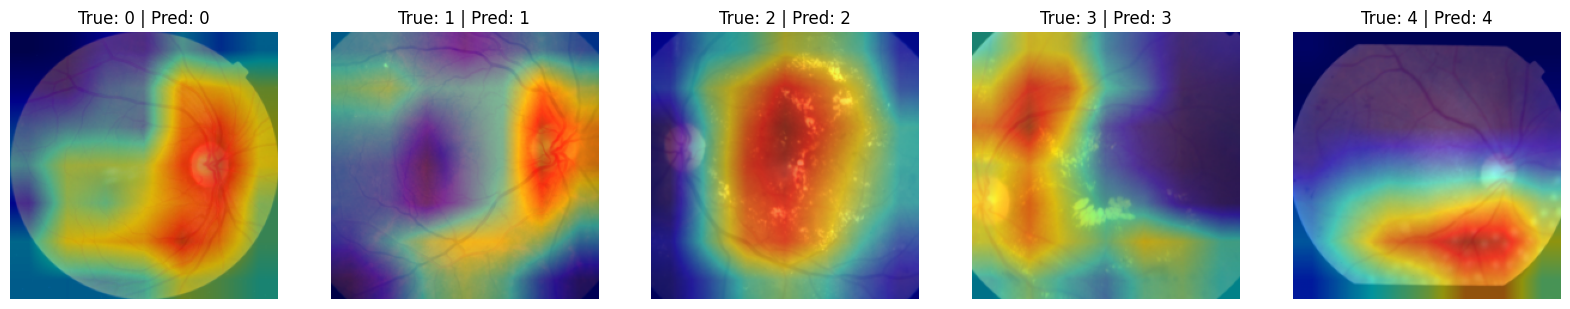

In [119]:
visualize_gradcam(model, test_dataset, [4, 29, 6, 30, 86])
# 4, 9

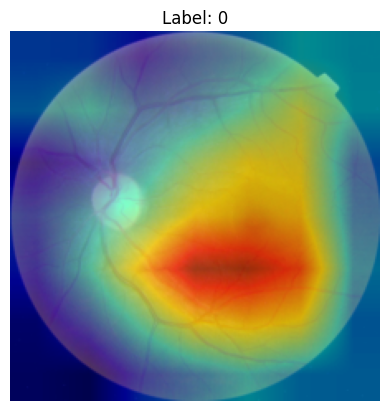

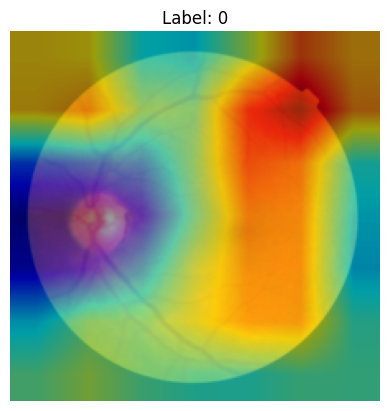

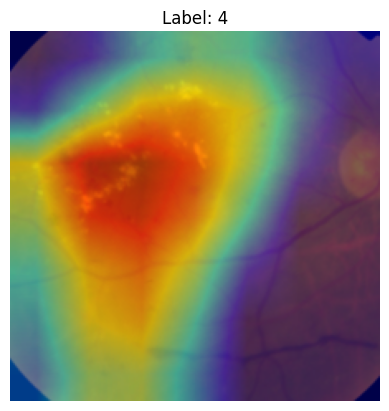

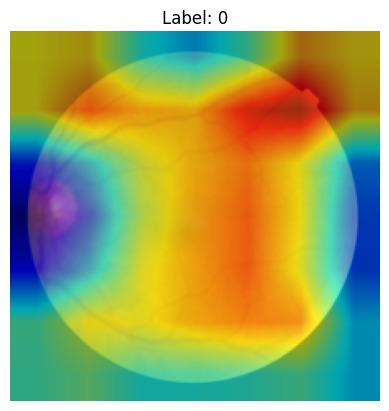

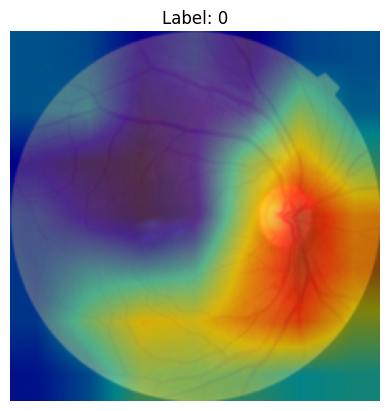

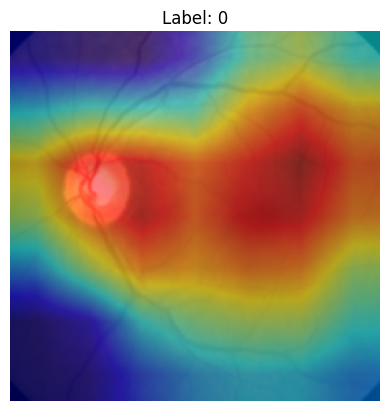

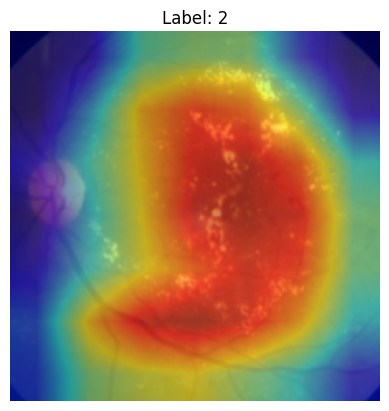

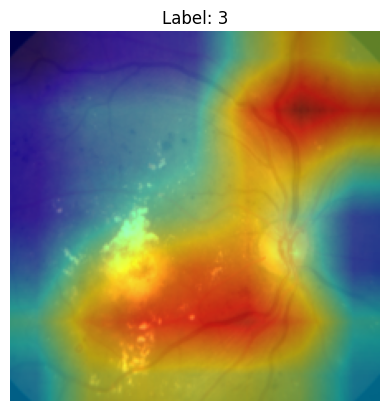

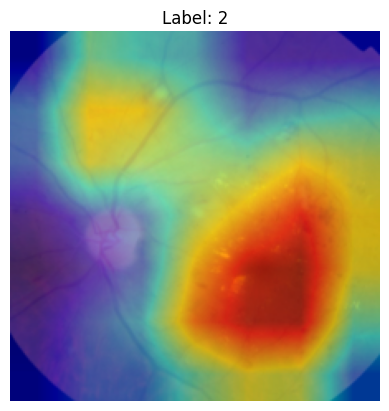

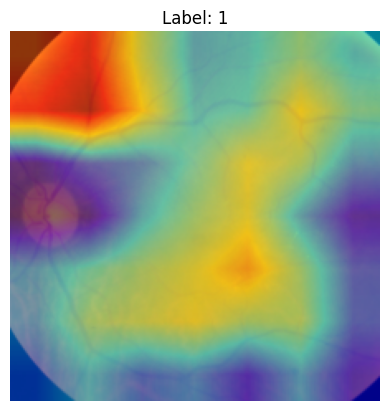

In [69]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import torch
import numpy as np
import matplotlib.pyplot as plt

# Pick target layer (last conv layer of DenseNet121 backbone)
target_layer = model.densenet[-1]   # update to your architecture

# Create GradCAM object
cam = GradCAM(model=model, target_layers=[target_layer])

# Loop through the first 10 images from the test dataset
for i in range(10):
    # Get image and label from the test dataset
    input_tensor, label = test_dataset[i]
    input_tensor = input_tensor.unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Generate CAM for the current image
    grayscale_cam = cam(input_tensor=input_tensor)[0]

    # Convert the image tensor to numpy array and normalize
    rgb_img = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Apply GradCAM to the image
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Visualize the image with the GradCAM overlay and label
    plt.imshow(cam_image)
    plt.title(f"Label: {label.item()}")  # Show label as the title
    plt.axis('off')  # Turn off axes
    plt.show()


In [22]:
print(model.densenet) 


Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(96, 128, ke